### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# ML model (GOSS-LGBM) for Average Relative Humidity

##  Read Me

This scripts contains ML model building steps for the weather variable `Average Relative Humidity`. The ML model has been implemented using the [Gradient-based One-Side Sampling (GOSS)](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) algorithm from [LightGBM](https://lightgbm.readthedocs.io/en/stable/) library. Detail on why GOSS has been chosen for ML modeling has been described in `Discussion.ipynb`. The modeling involves the following steps-

1. Loading Data
2. Evaluation before model performance/relationship 
3. additional data filtering (if required) 
4. train-test data split 
5. Looking into Mutual Information (MI) score to select preliminary input variables
6. Model training + hyperparameter tuning
7. Train-test dataset performance evaluation
8. Evaluating model's predictor importance plot
9. Evaluation model performance for randomly selected dates from the test dataset
10. Estimating overall model perforamcne on test dataset
11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

__Note:__
- the functions for building ML model, hyperparameter optimization, model performance evaluation, and daily improved-resolution weather data generation (interpolation) can be found at `ML_utils.ipunb` script.
- the functions for building Multi-Layered Perceptrons (MLP) model with Pytorch library and generating daily improved-resolution weather datasets can be found at `NN_Pytorch.ipunb` script.
- the general functions for  for raster data handling, era5/twc data processing/compilation, and folder handling can be found at `general_utils.ipunb` script.

In [1]:
from ipynb.fs.full.general_utils import *
from ipynb.fs.full.ML_utils import *

-----------

## 1. Loading Data

The `combined dataset` parquet file consists of weather datasets from ERA5 and TWC, along with topography and lat/lon data. Importing ERA5 and TWC datasets as well to briefly look into which variables belong to which source. 

In [2]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
twc_data= '../../datasets/processed_parquet_data/cities_California/twc_parquet/twc_historic_weatherdata.parquet'
combined_dataset =  '../../datasets/processed_parquet_data/cities_California/twc_era5_weather_data_cities_California.parquet'

twc_df =pd.read_parquet(twc_data)
era5_df = pd.read_parquet(era5_data)
combined_df = pd.read_parquet(combined_dataset)

print(f'TWC df columns: {twc_df.columns}')
print(f'ERA5 df columns: {era5_df.columns}')
print(f'TWC ERA5 df columns: {combined_df.columns}')

TWC df columns: Index(['index', 'avg_wind_speed', 'date', 'year', 'month', 'day', 'lon', 'lat',
       'avg_Rhumid', 'max_temp', 'min_temp'],
      dtype='object')
ERA5 df columns: Index(['MaxNet_SR', 'date', 'elevation', 'min_Rhumid', 'min_dew_temp',
       'max_atmPress', 'lat', 'lon', 'max_wind_speed', 'aspect', 'MaxDown_SR',
       'TotNet_SR', 'min_temp', 'max_temp', 'max_Rhumid', 'TotDown_SR',
       'min_wind_speed', 'total_precip', 'avg_wind_speed', 'eto',
       'min_atmPress', 'slope', 'avg_Cloud', 'avg_atmPress', 'max_dew_temp',
       'avg_SM_L1', 'avg_dew_temp', 'avg_wind_dir', 'avg_Rhumid', 'etr',
       'avg_ST_L1', 'avg_snow_depth'],
      dtype='object')
TWC ERA5 df columns: Index(['index', 'avg_wind_speed_twc', 'date', 'year', 'month', 'day', 'lon',
       'lat', 'avg_Rhumid_twc', 'max_temp_twc', 'min_temp_twc', 'MaxNet_SR',
       'elevation', 'min_Rhumid', 'min_dew_temp', 'max_atmPress',
       'max_wind_speed', 'aspect', 'MaxDown_SR', 'TotNet_SR', 'min_temp_era5',


---------------

## 2. Additional data filtering (if required)

No additional data filtering was required for this particular model.

---------------------

## 3. Evaluation before model performance/relationship

We resample 28km ERA5 `Average Relative Humidity` data to 4km resolution and compare with TWC `Average Relative Humidity` (4km) Data to understand how the `R2` value looks like between these variables before implementing machine learning model. 

RMSE before modeling = 8.314
R2 before modeling= 0.797


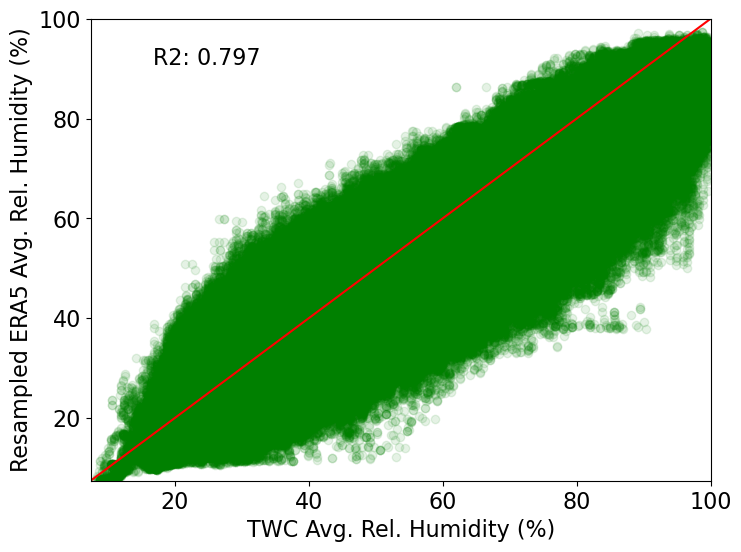

In [24]:
## ERA5 and TWC Total Precipitation relationship before RF model
rmse = calculate_rmse(Y_pred=combined_df['avg_Rhumid_era5'], Y_obsv=combined_df['avg_Rhumid_twc'])
r2 = calculate_r2(Y_pred=combined_df['avg_Rhumid_era5'], Y_obsv=combined_df['avg_Rhumid_twc'])

print('RMSE before modeling = {:.3f}'.format(rmse))
print('R2 before modeling= {:.3f}'.format(r2))

scatter_plot(Y_pred=combined_df['avg_Rhumid_era5'], Y_obsv=combined_df['avg_Rhumid_twc'], 
             xlabel='TWC Avg. Rel. Humidity (%)', 
             ylabel='Resampled ERA5 Avg. Rel. Humidity (%)', title=None, 
             savedir=None, plot_name=None, alpha=0.1, color_format='go')

### Goal

The R2 value between TWC and ERA5 avg. rel. humidity is quite well. However, We will try Machine Learning model to see if we can use ERA5 datasets as predictors to predict high resolution avg. rel. humidity using TWC avg. rel. humidity as the training data.

-----------------

## 4. Making train-test split

__Input variables:__ Weather variables from ERA5 renanalysis dataset, along with topography, lat/lon, month datasets, have been used as input variables/predictors in the ML model. All TWC dataset, except the training data TWC `average relative humidity`, has been removed from train-test datasets. 
__Observed/training data:__ TWC `average relative humidity` has been used as the training/observed data.

In [3]:
drop_columns = ['index', 'year', 'day',
                'min_temp_twc', 'avg_wind_speed_twc', 'max_temp_twc',
                'avg_ST_L1', 'avg_SM_L1', 'avg_snow_depth', 
                'eto', 'etr', 'min_atmPress', 'avg_atmPress', 'min_wind_speed',
                'slope', 'aspect']

x_train, x_val, x_test, y_train, y_val, y_test, train_dates, validation_dates, test_dates= \
split_train_val_test_set_by_date(input_dataset_fp=combined_dataset, pred_attr='avg_Rhumid_twc', 
exclude_columns=drop_columns, test_perc=0.2, validation_perc=0)

Dropping Columns- ['index', 'year', 'day', 'min_temp_twc', 'avg_wind_speed_twc', 'max_temp_twc', 'avg_ST_L1', 'avg_SM_L1', 'avg_snow_depth', 'eto', 'etr', 'min_atmPress', 'avg_atmPress', 'min_wind_speed', 'slope', 'aspect'] 

Predictors: Index(['MaxDown_SR', 'MaxNet_SR', 'TotDown_SR', 'TotNet_SR', 'avg_Cloud',
       'avg_Rhumid_era5', 'avg_dew_temp', 'avg_wind_dir',
       'avg_wind_speed_era5', 'elevation', 'lat', 'lon', 'max_Rhumid',
       'max_atmPress', 'max_dew_temp', 'max_temp_era5', 'max_wind_speed',
       'min_Rhumid', 'min_dew_temp', 'min_temp_era5', 'month', 'total_precip'],
      dtype='object')


In [4]:
print('x_train length', len(x_train))
print('x_val length', len(x_val))
print('x_test length', len(x_test))
print(f'num. of training dates: {len(train_dates)}')
print(f'num. of validation dates: {len(validation_dates)}')
print(f'num. of test dates: {len(test_dates)}')

x_train length 3520439
x_val length 0
x_test length 879914
num. of training dates: 2286
num. of validation dates: 0
num. of test dates: 572


-------------------

## 5. Looking into Mutual Information (MI) score to select preliminary input variables

`MI score` and `feature importance plot` are ways to determine which predictors are most important in predicting the target variable.  The `MI score` and `predictor/feature importance plot` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

TotDown_SR_era5      0.258975
TotNet_SR            0.229424
MaxDown_SR_era5      0.211164
MaxNet_SR            0.196157
avg_atmPress_era5    0.153241
max_atmPress         0.151941
min_atmPress         0.151518
min_Rhumid           0.145142
avg_Rhumid_era5      0.137351
max_Rhumid           0.136039
max_temp_era5        0.134484
min_temp_era5        0.123579
min_dew_temp         0.123574
avg_dew_temp         0.122390
max_dew_temp         0.118436
avg_wind_dir         0.115476
max_wind_speed       0.105968
avg_wind_speed       0.101145
etr                  0.095154
eto                  0.093049
min_wind_speed       0.088143
avg_Cloud_era5       0.085941
total_precip_era5    0.060145
lat                  0.048334
day                  0.048240
lon                  0.045000
month                0.023311
dtype: float64

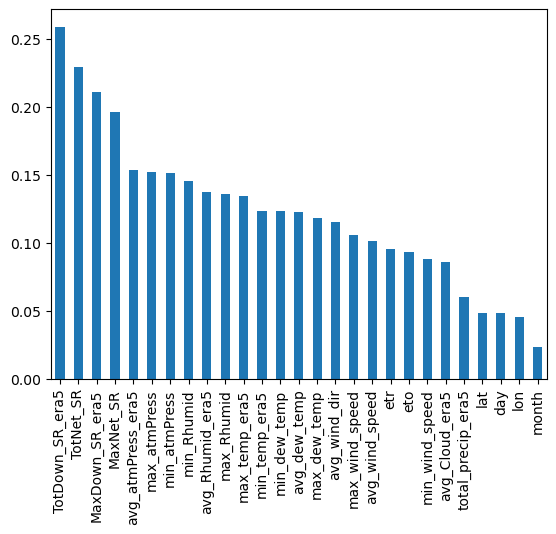

In [10]:
mutual_info_avgRhumid = calculate_plot_mutual_information(x_train=x_train, y_train=y_train)
mutual_info_avgRhumid

--------------------

## 6. Model training+hyperparamter tuning

Tuned GOSS (LightGBM) model for 09 hyperparameters with 10-fold Randomized CV. A total of 500 combinations of hyperparameters were tested. The hyperparameter space can be found at `ML_utils.ipynb` script. 

In [5]:
# the hyperparameters provided in the following dictionary have been set by hyperparameter tuning
lgbm_param_dict = {'n_estimators': 250,
                   'max_depth': 13,
                   'learning_rate': 0.05,
                   'subsample': 0.6,
                   'colsample_bytree': 0.8,
                   'colsample_bynode': 0.7 ,
                   'path_smooth': 0.1,
                   'num_leaves': 70,
                   'min_child_samples': 40,
                  }

# when tuning hyperparameters set params_dict=None.
trained_lgbm_Rhumid = train_model(x_train, y_train, params_dict=lgbm_param_dict, model='lgbm', n_jobs=-1,
                                 load_model=False, save_model=True, save_folder='./saved_models', save_name='lgbm_avg_Rhumid',
                                 # hyperparameter tuning arguments
                                 tune_hyperparameters=False, repeated_Kfold=False, n_folds=10, n_iter=50, n_repeats=5)

[LightGBM] [Info] Total Bins 5041
[LightGBM] [Info] Number of data points in the train set: 3520439, number of used features: 22
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 56.251041
Train RMSE = 4.174
Train R2 = 0.948
model training time 0.428 mins


In [6]:
trained_lgbm_Rhumid

LGBMRegressor(colsample_bynode=0.7, colsample_bytree=0.8,
              data_sample_strategy='goss', deterministic=True,
              force_row_wise=True, learning_rate=0.05, max_depth=13,
              min_child_samples=40, n_estimators=250, n_jobs=-1, num_leaves=70,
              path_smooth=0.1, random_state=0, subsample=0.6,
              tree_learner='serial')

------------

## 7. Train-test dataset perforamnce evaluation

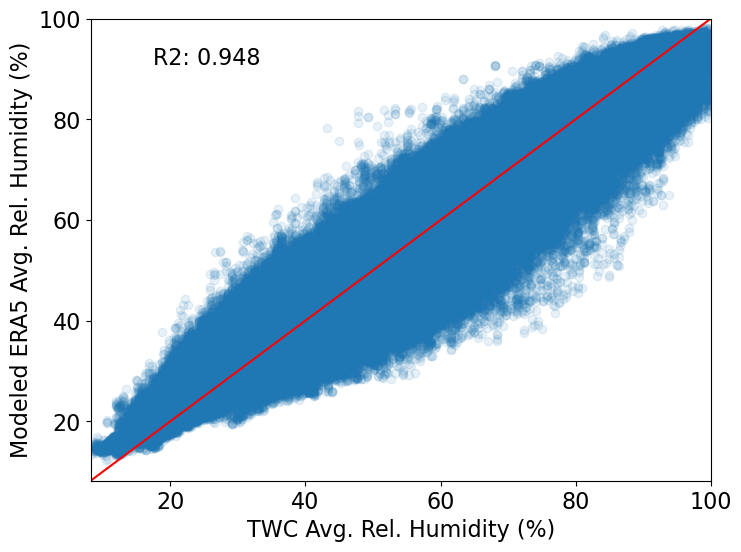

In [6]:
# Performance on train dataset
y_pred_train = trained_lgbm_Rhumid.predict(x_train)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_train, 
             xlabel='TWC Avg. Rel. Humidity (%)', ylabel='Modeled ERA5 Avg. Rel. Humidity (%)', 
             title=None, savedir=None, plot_name=None, alpha=0.1)

Test RMSE = 4.695
Test R2 = 0.940


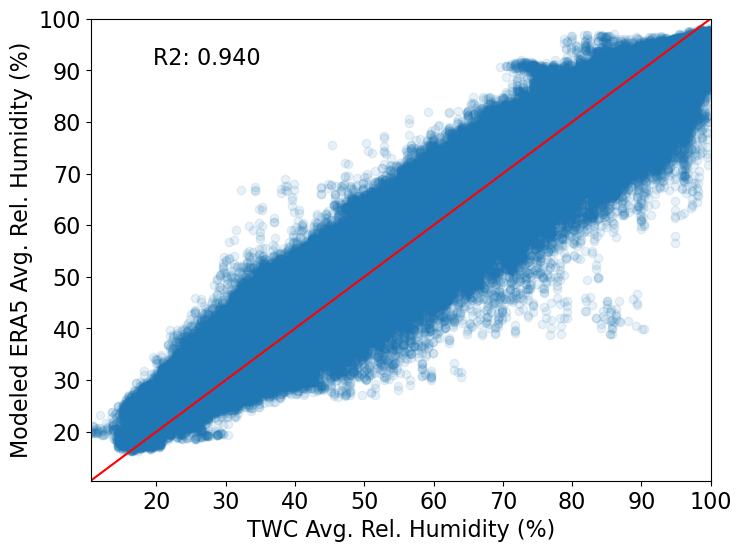

In [7]:
# Performance on test dataset
y_pred_test = trained_lgbm_Rhumid.predict(x_test)
print('Test RMSE = {:.3f}'.format(calculate_rmse(Y_pred=y_pred_test, Y_obsv=y_test)))
print('Test R2 = {:.3f}'.format(calculate_r2(Y_pred=y_pred_test, Y_obsv=y_test)))

scatter_plot(Y_pred=y_pred_test, Y_obsv=y_test, 
             xlabel='TWC Avg. Rel. Humidity (%)', ylabel='Modeled ERA5 Avg. Rel. Humidity (%)', 
             title=None, savedir=None, plot_name=None, alpha=0.1)

---------------

## 8. Evaluating model's predictor importance plot

The `predictor/feature importance plot` is a way of seeing which input variables are regarded the most important by the model. The predictor importance plot here is based on `Impurity-based feature importance` which is prone to high-cardinality. I would recoomend looking into [permutation importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) to have a more rigorous understanding of feature importance. The `predictor/feature importance plot` and `MI score` have to be inspected repeatedly with differnet combinations of input variables to find the optimum set of input variables with best model performance.

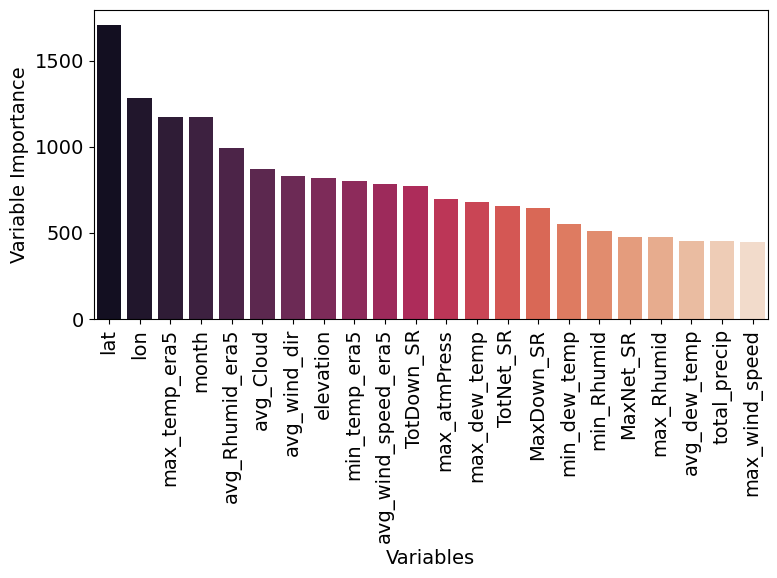

In [10]:
# preditor importance plot
plot_predictor_importance(trained_model=trained_lgbm_Rhumid, x_train=x_train, outdir=None, predictor_imp_keyword='rf')

---------------

## 9. Evaluation model performance for randomly selected dates from the test dataset

Our objective is to improve spatial resolution of daily weather datasets. So, we chcek model performance on randomly selected dataes from the test datasets.

In [11]:
test_dates[1:20]

[20181018,
 20201001,
 20191215,
 20161127,
 20200713,
 20211226,
 20180825,
 20191107,
 20190731,
 20200704,
 20190825,
 20191130,
 20200818,
 20161113,
 20160423,
 20220115,
 20211104,
 20191001,
 20220617]

In [12]:
# to check if a date is in test dataset
if 20210923 in test_dates:
    print(True)

True


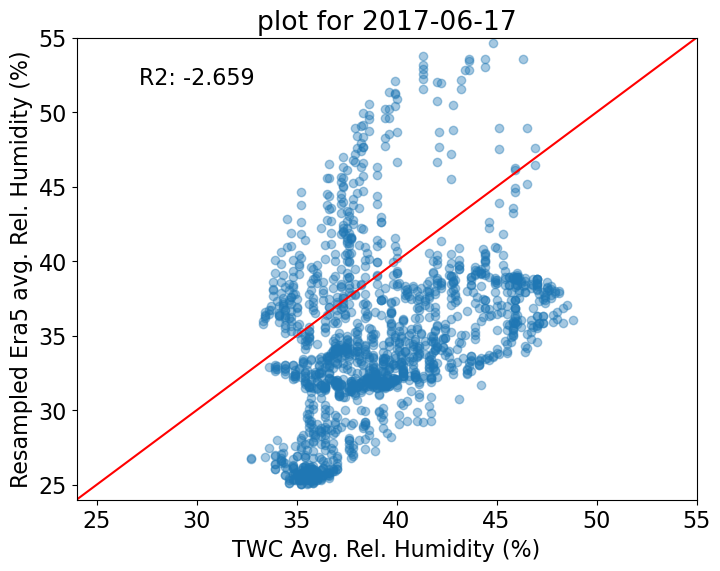

In [8]:
twc_era5_df_sample = combined_df[combined_df.date==20170617]
era5_maxtemp = twc_era5_df_sample['avg_Rhumid_era5'] 
y_02 = twc_era5_df_sample[['avg_Rhumid_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Avg. Rel. Humidity (%)', ylabel='Resampled Era5 avg. Rel. Humidity (%)', 
             title='plot for 2017-06-17', alpha=0.4, axis_lim=[24, 55])

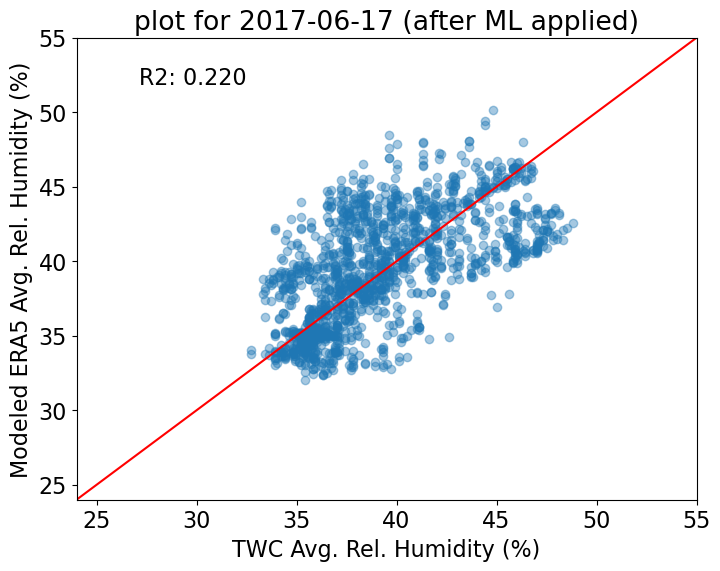

In [9]:
twc_era5_df_sample = combined_df[combined_df.date==20170617]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['avg_Rhumid_twc']].values

y_pred_train = trained_lgbm_Rhumid.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Avg. Rel. Humidity (%)', ylabel='Modeled ERA5 Avg. Rel. Humidity (%)', 
             title='plot for 2017-06-17 (after ML applied)', alpha=0.4, axis_lim=[24, 55])

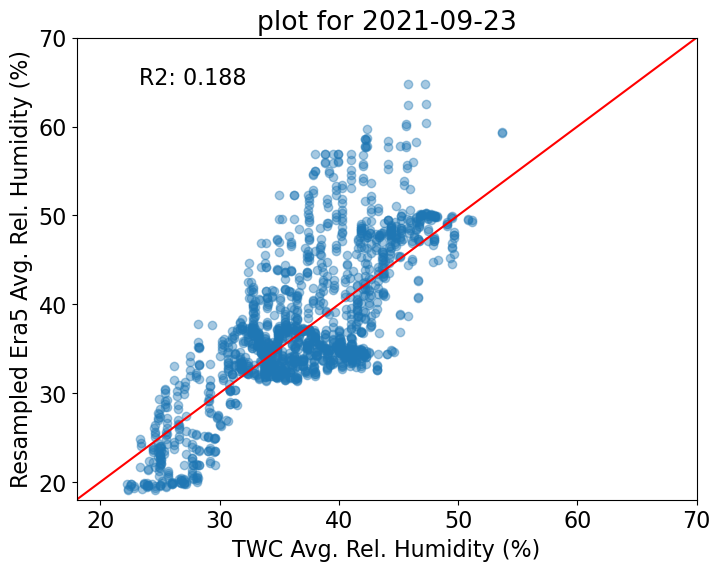

In [10]:
twc_era5_df_sample = combined_df[combined_df.date==20210923]
era5_maxtemp = twc_era5_df_sample['avg_Rhumid_era5'] 
y_02 = twc_era5_df_sample[['avg_Rhumid_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Avg. Rel. Humidity (%)', ylabel='Resampled Era5 Avg. Rel. Humidity (%)', 
             title='plot for 2021-09-23', alpha=0.4, axis_lim=[18, 70])

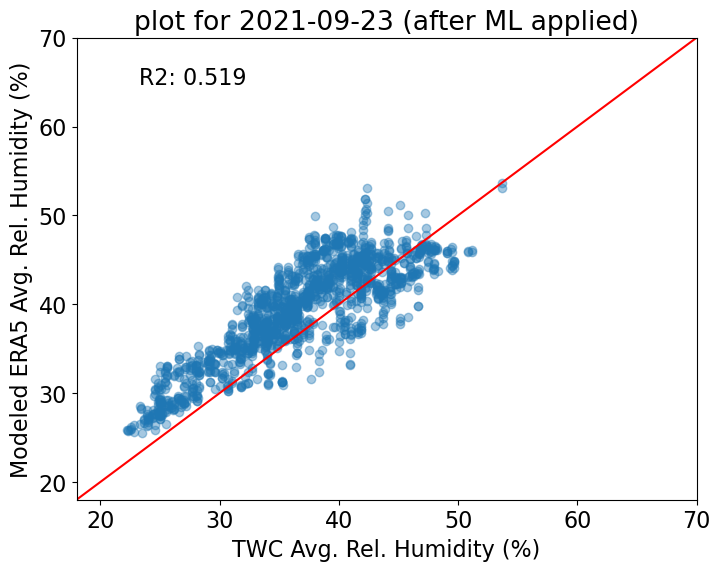

In [11]:
twc_era5_df_sample = combined_df[combined_df.date==20210923]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['avg_Rhumid_twc']].values

y_pred_train = trained_lgbm_Rhumid.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Avg. Rel. Humidity (%)', ylabel='Modeled ERA5 Avg. Rel. Humidity (%)', 
             title='plot for 2021-09-23 (after ML applied)', alpha=0.4, axis_lim=[18, 70])

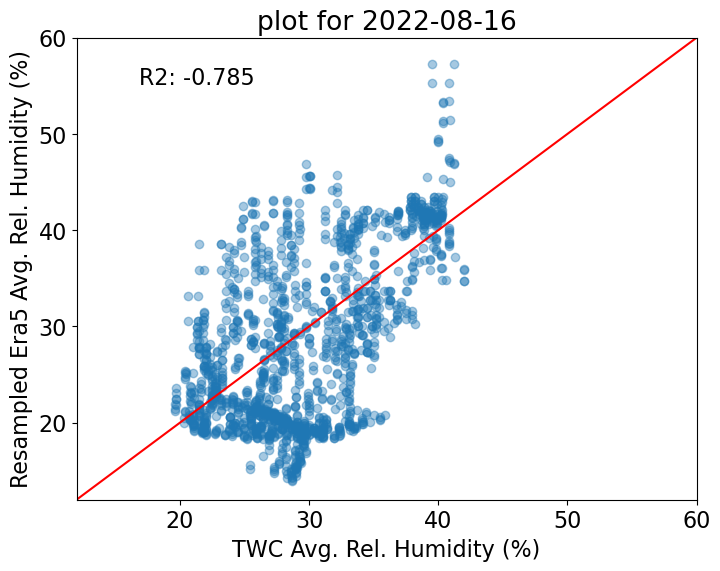

In [13]:
twc_era5_df_sample = combined_df[combined_df.date==20220816]
era5_maxtemp = twc_era5_df_sample['avg_Rhumid_era5'] 
y_02 = twc_era5_df_sample[['avg_Rhumid_twc']].values

scatter_plot(Y_pred=era5_maxtemp, Y_obsv=y_02, 
             xlabel='TWC Avg. Rel. Humidity (%)', ylabel='Resampled Era5 Avg. Rel. Humidity (%)', 
             title='plot for 2022-08-16', alpha=0.4, axis_lim=[12, 60])

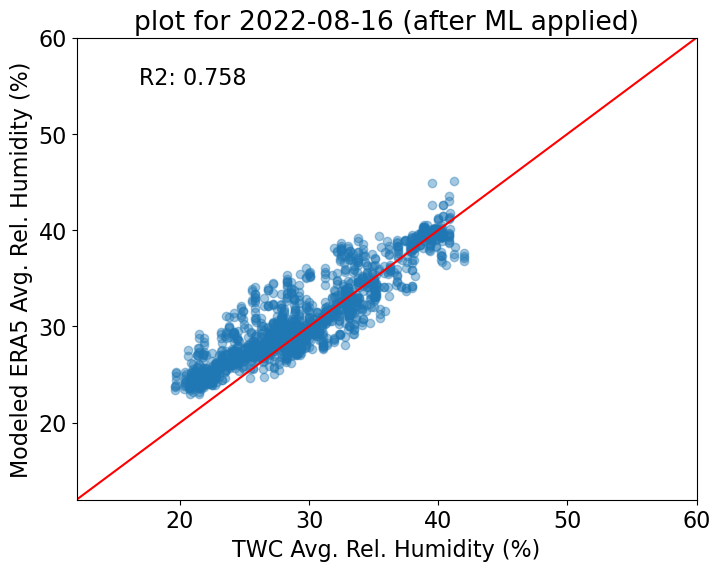

In [12]:
twc_era5_df_sample = combined_df[combined_df.date==20220816]
x_02 = twc_era5_df_sample[x_train.columns] 
x_02 = reindex_df(x_02)
y_02 = twc_era5_df_sample[['avg_Rhumid_twc']].values

y_pred_train = trained_lgbm_Rhumid.predict(x_02)

scatter_plot(Y_pred=y_pred_train, Y_obsv=y_02, 
             xlabel='TWC Avg. Rel. Humidity (%)', ylabel='Modeled ERA5 Avg. Rel. Humidity (%)', 
             title='plot for 2022-08-16 (after ML applied)', alpha=0.4, axis_lim=[12, 60])

__The plots of before and after modeling performance for randomly selected dates from test dataset shows that the model is performing quite well for individual dates.__

-----------

## 10. Estimating overall model perforamcne on test dataset

Here, we are looking into before and after modeling R2 score for all dates in the test dataset.

In [19]:
result_calc_test_dataset(trained_ml_model=trained_lgbm_Rhumid, list_test_dates=test_dates, x_train=x_train, 
                         combined_dataset=combined_dataset, era5_target_variable='avg_Rhumid_era5', 
                         twc_target_variable='avg_Rhumid_twc', 
                         output_csv='./saved_models/avg_Rhumid_test_results.csv')

572 number of total dates in test dataset
272 days have R2 > 0.6
326 days have R2 > 0.5
421 days have R2 > 0.3


,date,before_ML_R2,after_ML_R2
0,20200925,-0.654641,0.196576
1,20181018,-0.108694,0.816167
2,20201001,-0.197175,0.732853
3,20191215,-1.708100,-0.303563
4,20161127,-0.067583,0.363201
...,...,...,...
567,20201011,0.426145,0.785368
568,20201222,-0.465633,0.464969
569,20230401,-3.522134,-0.112137
570,20181004,-2.834435,0.216393


In [33]:
import seaborn as sns

results_csv = './saved_models/avg_Rhumid_test_results.csv'
results_df = pd.read_csv(results_csv)

R2_below_zero_before_model = len(results_df[results_df['before_ML_R2']<0])
R2_below_zero_after_model = len(results_df[results_df['after_ML_R2']<0])

print(f'Before ML model {R2_below_zero_before_model} R2 remains negative')
print(f'After ML model {R2_below_zero_after_model} R2 remains negative')

Before ML model 377 R2 remains negative
After ML model 75 R2 remains negative


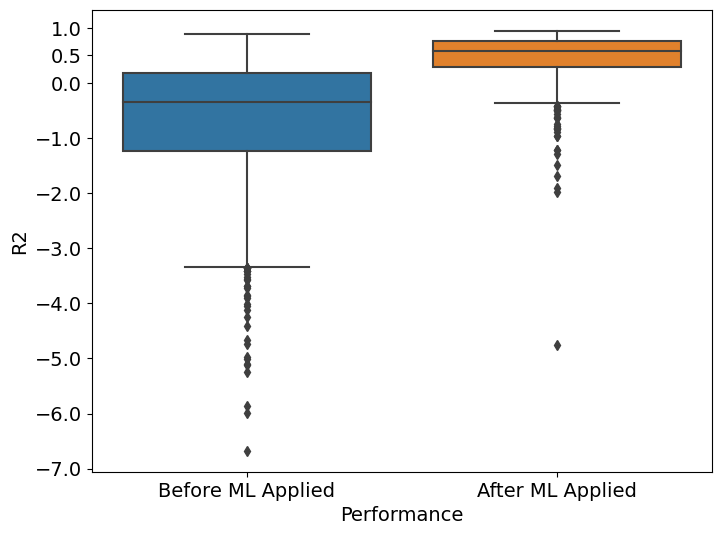

In [34]:
# Boxplot of before and after ML performance
results_df = results_df[['before_ML_R2', 'after_ML_R2']]
results_df = results_df.rename(columns={'before_ML_R2': 'Before ML Applied', 'after_ML_R2': 'After ML Applied'})
results_df = results_df[results_df['Before ML Applied']>-7]

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='variable', y='value', data=pd.melt(results_df))
ax.set_xlabel('Performance')
ax.set_ylabel('R2')
ax.set_yticks([-7, -6, -5, -4, -3, -2, -1, 0, 0.5, 1])

__The boxplot of before and after modeling R2 proves that the model is performing very well. From negative to very low R2 values, the model increases the R2 value which proves that the model interpolates the the daily weather data at high-resolution succesfully.__

----------------------

## 11. Generating daily high-resolution data records using the trained model for an extended timeline (2002-2023)

In [20]:
era5_data= '../../datasets/processed_parquet_data/cities_California/era5_parquet/4km_era5_daily_data.parquet'
ref_raster = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/avg_Rhumid/avg_Rhumid_20150630.tif'
output_folder = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_Rhumid'

run_model_to_generate_prediction(trained_ml_model=trained_lgbm_Rhumid, x_train=x_train, 
                                 predictor_era5_dataset=era5_data, ref_raster=ref_raster, 
                                 output_folder=output_folder, variable_name_keyword='avg_Rhumid')

Generating model interpolated daily rasters...
All daily rasters generated


### Visualization of downscaled results 

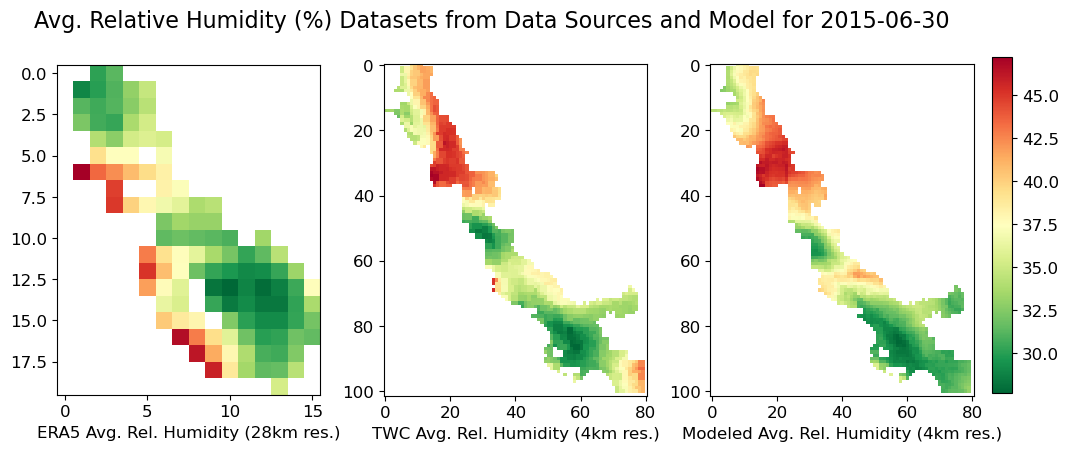

In [4]:
era5_data = '../../datasets/weather_raster_data/cities_California/era5_data/original_28km_rasters/avg_Rhumid/avg_Rhumid_20150630.tif'
twc_data = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/avg_Rhumid/avg_Rhumid_20150630.tif'
downscaled_data = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_Rhumid/avg_Rhumid_20150630.tif'


plot_era5_twc_downscaled_rasters(era5_data, twc_data, downscaled_data,  
                                 title= 'Avg. Relative Humidity (%) Datasets from Data Sources and Model for 2015-06-30',
                                 suptitle_pos=0.75,
                                 xlabels=['ERA5 Avg. Rel. Humidity (28km res.)',
                                          'TWC Avg. Rel. Humidity (4km res.)',
                                          'Modeled Avg. Rel. Humidity (4km res.)'],
                                 cbar_axes_pos=[1, 0.27, 0.02, 0.42])